# Dogs-vs-not-dogs evaluation in Imagenet


The two subsets of the imagenet dataset are from this [Dropbox link](https://www.dropbox.com/sh/yrfmp7hwa2w9gxz/AAATMrfWNLctPq1vnRa3mtZPa?dl=0). We use the `dogs50A-train.tar.gz` and `non-dogs-val.tar.gz` subsets. Extract these into the respective folders and change the paths accordingly int his script.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import torch

In [ ]:
from PIL import Image
class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img


In [ ]:
import os
import glob

def list_file_types(directory):
    # ensure the directory path ends with a separator
    if not directory.endswith(os.path.sep):
        directory += os.path.sep
    
    # recursive glob pattern to match all files
    glob_pattern = directory + '**/*.*'
    
    # set to store unique file extensions
    file_types = set()
    
    # recursively search for all files with an extension
    for file in glob.glob(glob_pattern, recursive=True):
        # extract file extension and add to the set
        _, ext = os.path.splitext(file)
        if ext:  # check if extension is not empty
            file_types.add(ext.lower())  # add extension in lowercase to ensure uniqueness
    
    return file_types



In [ ]:
from torchvision import transforms

dog_folder = '/mnt/dogs50A-train'
dog_files = []
for root, dirs, files in os.walk(dog_folder):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
            dog_files.append(os.path.join(root, file))
print(len(dog_files))

nondog_folder = '/mnt/non-dogs-val'
nondog_files = []
for root, dirs, files in os.walk(nondog_folder):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
            nondog_files.append(os.path.join(root, file))
print(len(nondog_files))

transform_inception_with_crop = transforms.Compose([
    # transform,
    transforms.Resize(64),  # Inception models expect a 299x299 input size
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dog_dataset = ImagePathDataset(dog_files, transforms=transform_inception_with_crop)
nondog_dataset = ImagePathDataset(nondog_files, transforms=transform_inception_with_crop)




In [ ]:
plt.imshow(dog_dataset[0].permute(1, 2, 0))
plt.show()
plt.imshow(nondog_dataset[0].permute(1, 2, 0))
plt.show()

In [ ]:
from labproject.embeddings import FIDEmbeddingNet
net = FIDEmbeddingNet(device='cuda')



In [ ]:

dataloader = torch.utils.data.DataLoader(dog_dataset, batch_size=100, shuffle=False, num_workers=4)
dog_embeddings = net.get_embeddings(dataloader)

dataloader = torch.utils.data.DataLoader(nondog_dataset, batch_size=100, shuffle=False, num_workers=4)
nondog_embeddings = net.get_embeddings(dataloader)

In [ ]:
dog_embeddings.shape, nondog_embeddings.shape

In [ ]:
torch.save(dog_embeddings, '/mnt/dog_embeddings.pt')
torch.save(nondog_embeddings, '/mnt/nondog_embeddings.pt')

In [ ]:
dog_embeddings = torch.load('/mnt/dog_embeddings.pt')
nondog_embeddings = torch.load('/mnt/nondog_embeddings.pt')

In [ ]:
from labproject.metrics.gaussian_squared_wasserstein import gaussian_squared_w2_distance

print('dog nondog', gaussian_squared_w2_distance(dog_embeddings, nondog_embeddings))
print('dog dog', gaussian_squared_w2_distance(dog_embeddings[:3004], dog_embeddings[3004:]))
print('nondog nondog', gaussian_squared_w2_distance(nondog_embeddings[:2405], nondog_embeddings[2405:]))

In [ ]:
from labproject.metrics.MMD_torch import compute_rbf_mmd
print('dog nondog', compute_rbf_mmd(dog_embeddings, nondog_embeddings, 64))
print('dog dog', compute_rbf_mmd(dog_embeddings[:3004], dog_embeddings[3004:], 64))
print('nondog nondog', compute_rbf_mmd(nondog_embeddings[:2405], nondog_embeddings[2405:], 64))


In [ ]:
from labproject.metrics.c2st import c2st_nn
print('dog nondog', c2st_nn(dog_embeddings, nondog_embeddings))
dog_embeddings_shuffled = dog_embeddings[torch.randperm(dog_embeddings.size(0))]
print('dog dog', c2st_nn(dog_embeddings_shuffled[:3004], dog_embeddings_shuffled[3004:]))
nondog_embeddings_shuffled = nondog_embeddings[torch.randperm(nondog_embeddings.size(0))]
print('nondog nondog', c2st_nn(nondog_embeddings_shuffled[:2405], nondog_embeddings_shuffled[2405:]))


In [ ]:
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
print('dog nondog', sliced_wasserstein_distance(dog_embeddings[:4809], nondog_embeddings, 5000))
print('dog dog', sliced_wasserstein_distance(dog_embeddings[:3004], dog_embeddings[3004:], 5000))
print('nondog nondog', sliced_wasserstein_distance(nondog_embeddings[:2404], nondog_embeddings[2405:], 5000))


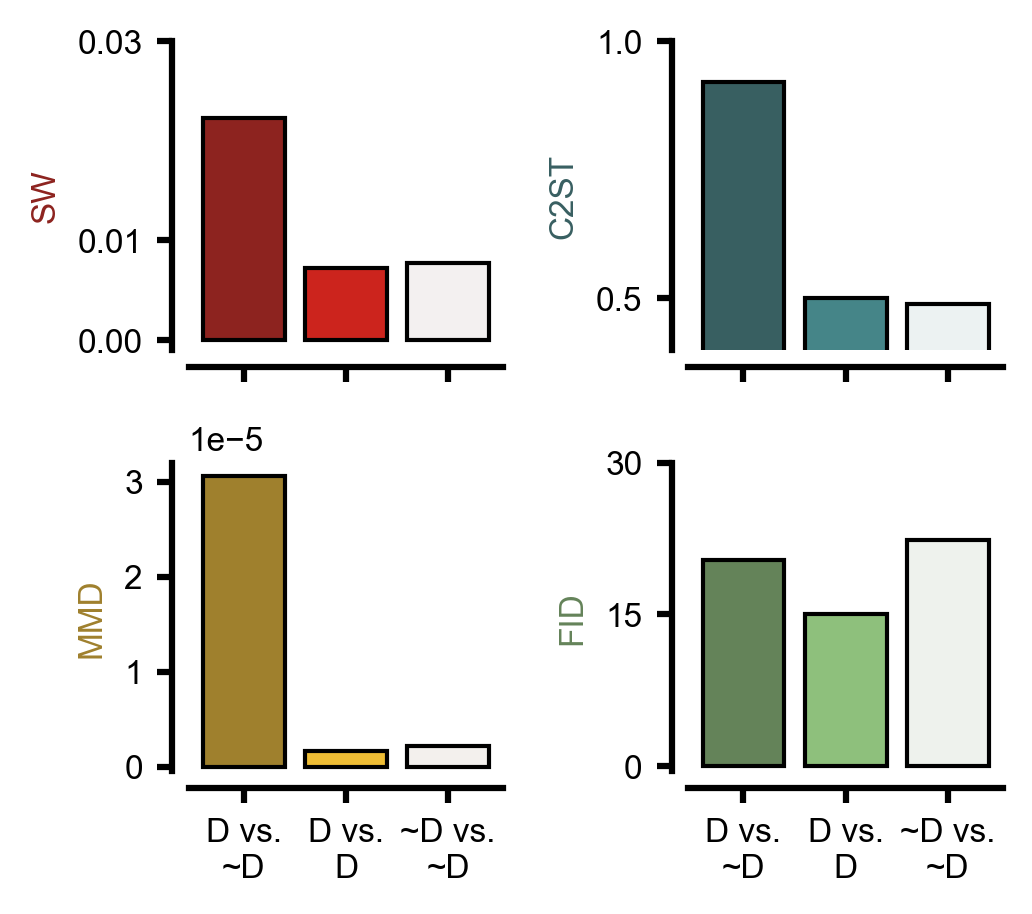

In [1]:
## plotting

from labproject.plotting import generate_palette
color_dict = {"SW": "#cc241d",
              "C2ST": "#458588",
              "MMD": "#eebd35",
              "FID": "#8ec07c"}


from omegaconf import OmegaConf
from labproject.experiments import *
from labproject.plotting import cm2inch
import time
import matplotlib.pyplot as plt
import sklearn


col_dark = {}
col_light = {}
for metric, color in color_dict.items():
    col_dark[metric] = generate_palette(color, saturation='dark')[2]
    col_light[metric] = generate_palette(color, saturation='light')[-1]




# precomputed metrics
intra_data = {metric:None for metric in ["C2ST", "MMD", "FID", "SW"]}
intra_data["FID"] = {"dog_nodog": 20.39, "dog_dog": 15.06, "nodog_nodog": 22.31}
intra_data["C2ST"] = {"dog_nodog": 0.92, "dog_dog": 0.50, "nodog_nodog": 0.49}
intra_data["MMD"] = {"dog_dog": 1.6689e-06, "dog_nodog": 3.0637e-05, "nodog_nodog": 2.1458e-06}
intra_data["SW"] = {"dog_dog": 0.0072, "dog_nodog": 0.0223, "nodog_nodog": 0.0077}

col_dark = {}
col_light = {}
col_lightest = {}
for metric, color in color_dict.items():
    col_dark[metric] = generate_palette(color, n_colors=6, saturation='dark')[3]
    col_light[metric] = generate_palette(color, n_colors=6, saturation='light')[-1]
    col_lightest[metric] = generate_palette(color, n_colors=6,saturation='light')[0]

# make comparison plots
fig, axes = plt.subplots(2, 2, figsize=cm2inch((9, 8)), dpi=300, sharex='col')

for ax in axes.flatten():
    # move spines outward
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['left'].set_position(('outward', 4))
    ax.locator_params(nbins=3)

# set fontsize to 10
plt.rcParams.update({'font.size': 10})
for i, (ax, metric) in enumerate(zip(axes.flatten(), color_dict.keys())):
    # move spines outward
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['left'].set_position(('outward', 4))
    ax.locator_params(nbins=3)

    intraclass1 = intra_data[metric]["dog_dog"]
    intraclass2 = intra_data[metric]["nodog_nodog"]
    interclass = intra_data[metric]["dog_nodog"]

    # barplot with different shadings
    ax.bar([0, 1, 2], [interclass, intraclass1, intraclass2], color=[col_dark[metric], col_light[metric], col_lightest[metric]], edgecolor='black')

    ax.set_ylabel(metric, color=col_dark[metric])
    if metric == 'C2ST':
        ax.set_ylim([0.4,1])
        ax.set_yticks([0.5,1])
    if metric == 'FID':
        ax.set_ylim([-0.5,30])
        ax.set_yticks([0,15,30])
    if metric == 'MMD':
        ax.set_ylim([-5e-7,3.2e-5])
        ax.set_yticks([0,1e-5,2e-5,3e-5])
    if metric == 'SW':
        ax.set_ylim([-0.001,0.03])
        ax.set_yticks([0,0.01,0.03])

    if i >=2:
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(['D vs.\n~D', 'D vs.\nD', '~D vs.\n~D'])
    else:
        ax.set_xticks([])

    
fig.tight_layout()
plt.show()
